In [1]:
import uproot4 as uproot
import matplotlib.pyplot as plt
import numpy as np
import math
import hist
import mplhep

import scipy

from scipy.optimize import curve_fit

root_name = ['RunData-20221017-83800751_PLOTS.root',
             'RunData-20221018-1289979_PLOTS.root',
             'RunData-20221018-4410040_PLOTS.root',
             'RunData-20221018-5262581_PLOTS.root',
             'RunData-20221018-6807935_PLOTS.root']

def tree_names():    
    tree_names = [[None]*1]*32
    for i in range (0,32):
        if i <10:
            tree_names[i] = 'ToA_ToT_board2_ch0' + str(i) + '_MCP_pixOn'
        else:
            tree_names[i] = 'ToA_ToT_board2_ch' + str(i) + '_MCP_pixOn'
    return  tree_names


In [2]:
def import_data(root_name,tree_name):
    '''
    a function which imports data from the CERN ROOT file,
    given the name of the root file & the tree that you 
    want to extract data from.
    '''
    root = uproot.open(root_name)
    tree = root[tree_name]
    
    h = uproot.models.TH.Model_TH2D_v4.to_hist(tree)
    
    w,x,y = h.to_numpy()
    return w,x,y,h

In [16]:
#Importing the data from the root file. The index passed into
#tree_names() is the channel number, eg. ch28
#Change the numbers in square brackets to change the run and pixel
#that the analysis is applied to.

name = tree_names()[28]
root = root_name[4]
w,ToT,ToA,h = import_data(root,name)
print('no of photons in this channel = ' + str(w.sum()))

no of photons in this channel = 9295.0


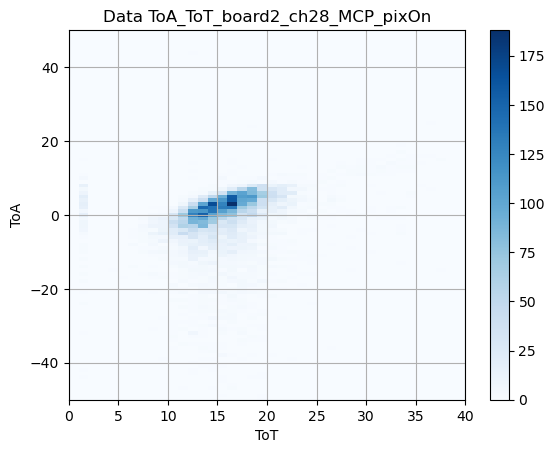

In [4]:
#Plotting a 2D histogram of the data before applying any corrections.

plt.pcolormesh(ToT, ToA, w.T,cmap='Blues')
plt.xlabel('ToT')
plt.ylabel('ToA')
plt.ylim([-50,50])
plt.xlim([0,40])
plt.title('Data ' + name)
plt.grid()
plt.colorbar()
plt.savefig('ToAvsToTboard2ch19mcppixon.png')
plt.show()

In [5]:
#Calculating the mean values of ToA at each ToT slice
mean_ToA = []

for y in w:
    try:
        mean_ToA.append(np.sum(y*np.arange(-224,225,1))/y.sum())
    except:
        mean_ToA.append()
mean_ToA = np.asarray(mean_ToA)
mean_ToA = np.nan_to_num(mean_ToA)

/var/folders/8k/h3kxl_651x3cg0_0vcmg27wc0000gn/T/ipykernel_37438/1355724202.py:6: RuntimeWarning: invalid value encountered in double_scalars
  mean_ToA.append(np.sum(y*np.arange(-224,225,1))/y.sum())


In [6]:
#Removing all the empty columns and rows, where there are 0 events,
#from the data. '_popped' is a reference to list.pop() which removes
#elements from a list

indices =[]   
ToA_popped = []
for i in range(0,len(y)-1):
    if w.T[i][:].sum() != 0:
        indices.append(i)
    else:
        pass
for i in indices:
    ToA_popped.append(y[i])
    
indices =[]   
ToT_popped = []
mean_popped = []
for i in range(0,len(ToT)-1):
    if w[i][:].sum() != 0:
        indices.append(i)
    else:
        pass
for i in indices:
    ToT_popped.append(ToT[i])
    mean_popped.append(mean_ToA[i])

ToT_popped = np.array(ToT_popped) 
ToA_popped = np.array(ToA_popped)
mean_popped = np.array(mean_popped)


Result = w[:,~np.all(w == 0, axis = 0)]
Result = Result.T[:,~np.all(Result.T == 0, axis = 0)]
w_popped = Result

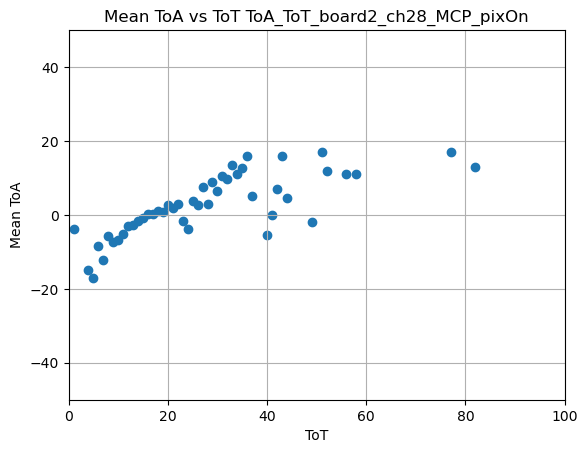

In [7]:
#Plotting the Mean ToA against ToT. Without removing the empty values
#from the data, there would be a lot of data points along the 
#Mean ToA = 0 axis which would affect the fitting of a function
#to the data.
plt.scatter(ToT_popped,mean_popped)
plt.ylim([-50,50])
plt.xlim([0,100])
plt.xlabel('ToT')
plt.ylabel('Mean ToA')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Mean ToA vs ToT ' + name)

#plt.legend()
plt.grid()
plt.show()


In [8]:
#Defining a function and fitting it to the
#mean ToA vs ToT data for this channel.
#The form of the function which needs
#to be fitted will not necessarily be this,
#change to suit the channel that you are using

def polynomial(x,f,a,b,c,d,e,g,h,j):
    return  a + b * x + c*x**2 + d * x**3  + e *x**4  +  f * np.log(g* x + h) + j * x**5

fit,cov = curve_fit(polynomial,ToT_popped, mean_popped,sigma = np.sqrt((w_popped.sum(axis=0)))/w_popped.sum(axis=0),maxfev=100000000)

/var/folders/8k/h3kxl_651x3cg0_0vcmg27wc0000gn/T/ipykernel_37438/1176236706.py:5: RuntimeWarning: invalid value encountered in log
  return  a + b * x + c*x**2 + d * x**3  + e *x**4  +  f * np.log(g* x + h) + j * x**5


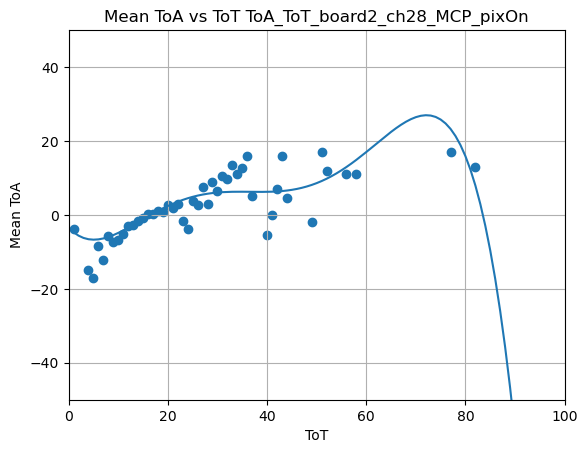

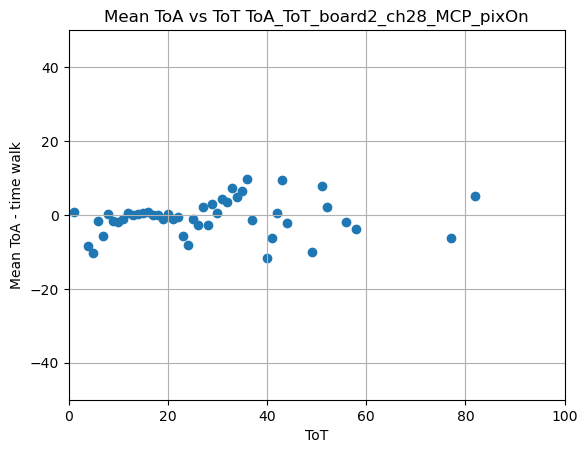

In [9]:
#Plotting the data and the fitted curve on the same axes.

plt.plot(ToT,polynomial(ToT,fit[0],fit[1],fit[2],fit[3],fit[4],fit[5],fit[6],fit[7],fit[8]))
plt.scatter(ToT_popped,mean_popped)
plt.ylim([-50,50])
plt.xlim([0,100])
plt.xlabel('ToT')
plt.ylabel('Mean ToA')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Mean ToA vs ToT ' + name)

#plt.legend()
plt.grid()
plt.savefig('meanToAvsToTwithFitboard2ch19mcppixon.png')
plt.show()

#Subtracting the time walk from the Mean ToA and plotting this against 
#the ToT. If the mean ToA is roughly centred on 0 which is encouraging

plt.scatter(ToT_popped,mean_popped - polynomial(ToT_popped,
                                                fit[0],
                                                fit[1],
                                                fit[2],
                                                fit[3],
                                               fit[4],fit[5],fit[6],fit[7],fit[8])
                                               )

plt.ylim([-50,50])
plt.xlim([0,100])
plt.xlabel('ToT')
plt.ylabel('Mean ToA - time walk')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Mean ToA vs ToT ' + name)

#plt.legend()
plt.grid()
plt.savefig('TWCmeanToAvsToTwithFitboard2ch19mcppixon.png')
plt.show()

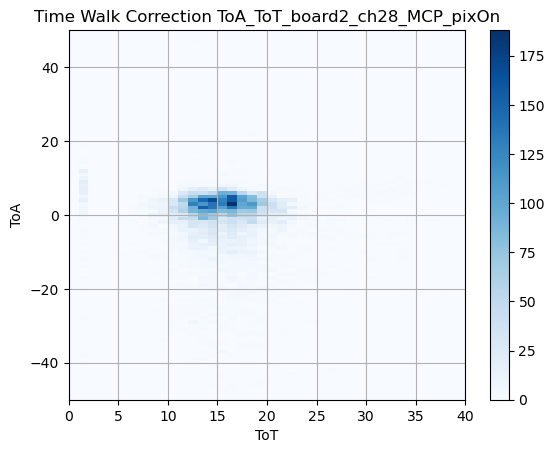

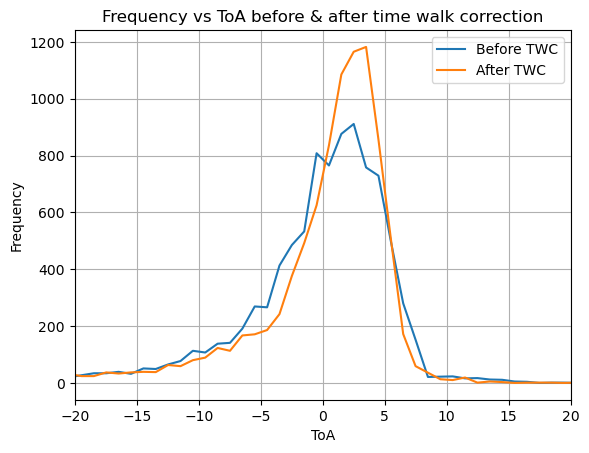

In [10]:
#Taking a vertical slice of the data & subtracting the time walk,
#then repeating for each vertical slice and plotting plt.pcolormesh
#really didn't want to cooperate and so it took way longer than it
#should have to get this to work. Finally, I'm also plotting ToA vs
#Frequency before and after the time walk is subtracted. Each slice
#is plotted individually. It is clear to see that the means is 
#shifted closer to zero, but it appears that a tail still remains.

time_walks = []
for i in range (0,w.shape[0]):
    time_walk = polynomial(ToT[i],fit[0],fit[1],fit[2],fit[3],fit[4],fit[5],fit[6],fit[7],fit[8])
    time_walks.append(time_walk)
    
twc = np.empty([w.shape[0],w.shape[1]])
for i in range(0,w.shape[0]):
    indx = np.digitize(ToA + time_walks[i],ToA) 
    for j in range(0,len(indx)):
        if indx[j]>448:
            indx[j] = 448
    indx = indx[0:-1]
    twc[i] = w[i][indx]
    
plt.pcolormesh(ToT, ToA, twc.T,cmap='Blues')
plt.xlabel('ToT')
plt.ylabel('ToA')
plt.ylim([-50,50])
plt.xlim([0,40])
plt.title('Time Walk Correction ' + name)
plt.grid()
plt.colorbar()
plt.show()
    

plt.plot(ToA[0:-1],w.sum(axis=0),label='Before TWC')
plt.xlim([-20,20])
plt.title('Frequency vs ToA before & after time walk correction')
plt.xlabel('ToA')
plt.ylabel('Frequency')

plt.plot(ToA[0:-1],twc.sum(axis=0),label='After TWC')
plt.xlim([-20,20])
plt.xlabel('ToA')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

In [11]:
def gaussian(x,r,sigma,N):
    return np.array(scipy.stats.norm.pdf(x,r,sigma)) * N

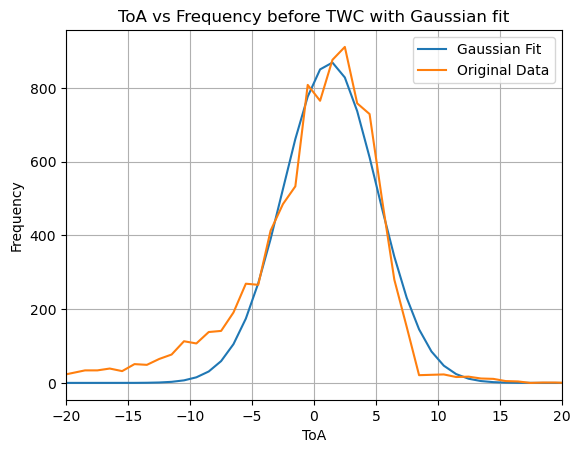

In [12]:
fit2,cov2 = curve_fit(gaussian,ToA[0:-1],w.sum(axis=0))
plt.plot(ToA[0:-1],gaussian(ToA[0:-1],fit2[0],fit2[1],fit2[2]),label='Gaussian Fit')
plt.plot(ToA[0:-1],w.sum(axis=0),label='Original Data')
plt.xlim([-20,20])
plt.legend()
plt.title('ToA vs Frequency before TWC with Gaussian fit')
plt.xlabel('ToA')
plt.ylabel('Frequency')
plt.grid()
plt.show()

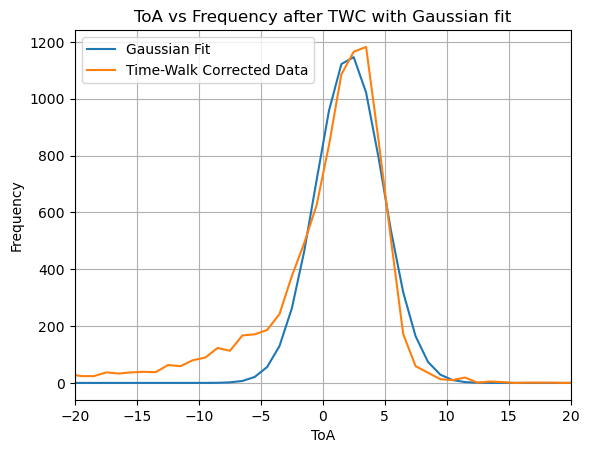

In [13]:
fit3,cov3 = curve_fit(gaussian,ToA[0:-1],twc.sum(axis=0),p0=(0,5,1000))
plt.plot(ToA[0:-1],gaussian(ToA[0:-1],fit3[0],fit3[1],fit3[2]),label='Gaussian Fit')
plt.plot(ToA[0:-1],twc.sum(axis=0),label='Time-Walk Corrected Data')
plt.xlim([-20,20])
plt.legend()
plt.title('ToA vs Frequency after TWC with Gaussian fit')
plt.xlabel('ToA')
plt.ylabel('Frequency')
plt.grid()
plt.show()


In [14]:
print('time resolution without the time walk correction is ' + str(fit2[1]))
print('time resolution with the time walk correction is ' + str(fit3[1]))

time resolution without the time walk correction is 3.791635268778838
time resolution with the time walk correction is 2.6993513430812413


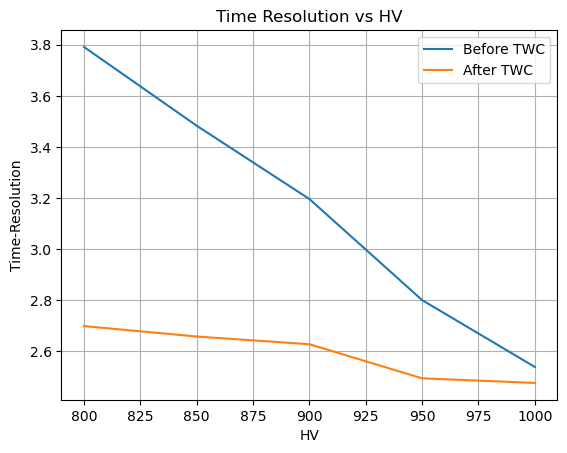

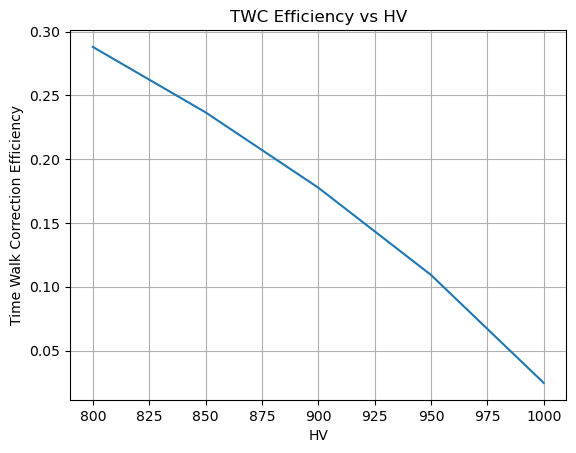

In [15]:
HV = [1000,950,900,850,800]

sigma_before = [2.539485194902906,2.8010578972580045,3.196553384748066,3.483326033534835, 3.791635268778838]

sigma_after = [2.47697425768142,2.4949759751327467,2.628456756607356,2.6585422164967603,2.6993513430812413]

plt.plot(HV,sigma_before,label='Before TWC')
plt.plot(HV,sigma_after,label='After TWC')
plt.legend()
plt.grid()
plt.title('Time Resolution vs HV')
plt.xlabel('HV')
plt.ylabel('Time-Resolution')
plt.show()

plt.plot(HV,1-np.array(sigma_after)/np.array(sigma_before))
plt.grid()
plt.title('TWC Efficiency vs HV')
plt.xlabel('HV')
plt.ylabel('Time Walk Correction Efficiency')
plt.show()